# DEMO

Demo包括此Notebook，目录下config.py文件，para_vgg16文件夹（文件夹内为model参数，包括：checkpoint，vgg16_faster_rcnn_iter_70000.ckpt文件系列）  

Faster RCNN网络结构图如下：

![caption](Faster_RCNN.jpg)



In [1]:
from config import cfg

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os, cv2

import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim import arg_scope

# 数据预处理

In [2]:
def im_list_to_blob(ims):
    """Convert a list of images into a network input.

    Assumes images are already prepared (means subtracted, BGR order, ...).
    """
    max_shape = np.array([im.shape for im in ims]).max(axis=0)
    num_images = len(ims)
    blob = np.zeros((num_images, max_shape[0], max_shape[1], 3),
                  dtype=np.float32)
    for i in range(num_images):
        im = ims[i]
        blob[i, 0:im.shape[0], 0:im.shape[1], :] = im

    return blob


def get_image_blob(im):
    im_orig = im.astype(np.float32, copy=True)
    im_orig -= cfg.PIXEL_MEANS

    im_shape = im_orig.shape
    im_size_min = np.min(im_shape[0:2])
    im_size_max = np.max(im_shape[0:2])

    processed_ims = []
    im_scale_factors = []

    for target_size in cfg.TEST.SCALES:
        im_scale = float(target_size) / float(im_size_min)
        if np.round(im_scale * im_size_max) > cfg.TEST.MAX_SIZE:
            im_scale = float(cfg.TEST.MAX_SIZE) / float(im_size_max)
        im = cv2.resize(im_orig, None, None, fx=im_scale, fy=im_scale, interpolation=cv2.INTER_LINEAR)
        im_scale_factors.append(im_scale)
        processed_ims.append(im)
    blob = im_list_to_blob(processed_ims)

    return blob, np.array(im_scale_factors)

In [3]:
img_path = "img"
img_name = "test.jpg"
im_file = os.path.join(img_path, img_name)
im = cv2.imread(im_file)

blobs = {}
blobs['data'], im_scale_factors = get_image_blob(im)
im_blob = blobs['data']
im_scales = im_scale_factors
blobs['im_info'] = np.array([im_blob.shape[1], im_blob.shape[2], im_scales[0]], dtype=np.float32)

# Test
# print(im.shape)
# print(blobs['data'].shape)
# print(blobs['im_info'])
# plt.imshow(im[:, :, (2, 1, 0)])
# plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
# plt.show()

# img_cell1 = blobs['data'][0]
# img_cell1 += cfg.PIXEL_MEANS
# img_cell1[img_cell1<1] = 1
# img_cell1[img_cell1>255] = 255
# img_cell1 = img_cell1.astype(np.uint8, copy=True)
# plt.imshow(img_cell1[:, :, (2, 1, 0)])
# plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
# plt.show()

# Build Network
# VGG16

In [4]:
class vgg16(object):
    def __init__(self):
        self._scope = 'vgg_16'


    def image_to_head(self, image, is_training, reuse=None):
        with tf.variable_scope(self._scope, self._scope, reuse=reuse):
            net = slim.repeat(image, 2, slim.conv2d, 64, [3, 3],
                              trainable=False, scope='conv1')
            net = slim.max_pool2d(net, [2, 2], padding='SAME', scope='pool1')
            net = slim.repeat(net, 2, slim.conv2d, 128, [3, 3],
                            trainable=False, scope='conv2')
            net = slim.max_pool2d(net, [2, 2], padding='SAME', scope='pool2')
            net = slim.repeat(net, 3, slim.conv2d, 256, [3, 3],
                            trainable=is_training, scope='conv3')
            net = slim.max_pool2d(net, [2, 2], padding='SAME', scope='pool3')
            net = slim.repeat(net, 3, slim.conv2d, 512, [3, 3],
                            trainable=is_training, scope='conv4')
            net = slim.max_pool2d(net, [2, 2], padding='SAME', scope='pool4')
            net = slim.repeat(net, 3, slim.conv2d, 512, [3, 3],
                            trainable=is_training, scope='conv5')
        return net
    
    
    def head_to_tail(self, pool5, is_training, reuse=None):
        with tf.variable_scope(self._scope, self._scope, reuse=reuse):
            pool5_flat = slim.flatten(pool5, scope='flatten')
            fc6 = slim.fully_connected(pool5_flat, 4096, scope='fc6')
            if is_training:
                fc6 = slim.dropout(fc6, keep_prob=0.5, is_training=True, 
                                    scope='dropout6')
            fc7 = slim.fully_connected(fc6, 4096, scope='fc7')
            if is_training:
                fc7 = slim.dropout(fc7, keep_prob=0.5, is_training=True, 
                                    scope='dropout7')
        return fc7

In [5]:
image = tf.placeholder(tf.float32, shape=[1, None, None, 3])
im_info = tf.placeholder(tf.float32, shape=[3])

net = vgg16()
net_conv = net.image_to_head(image, is_training=False)

# Test
print(net_conv)

Tensor("vgg_16/conv5/conv5_3/Relu:0", shape=(1, ?, ?, 512), dtype=float32)


# Generate Anchors

In [6]:
def whctrs(anchor):
    """
    Return width, height, x center, and y center for an anchor (window).
    """

    w = anchor[2] - anchor[0] + 1
    h = anchor[3] - anchor[1] + 1
    x_ctr = anchor[0] + 0.5 * (w - 1)
    y_ctr = anchor[1] + 0.5 * (h - 1)
    return w, h, x_ctr, y_ctr


def mkanchors(ws, hs, x_ctr, y_ctr):
    """
    Given a vector of widths (ws) and heights (hs) around a center
    (x_ctr, y_ctr), output a set of anchors (windows).
    """

    ws = ws[:, np.newaxis]
    hs = hs[:, np.newaxis]
    anchors = np.hstack((x_ctr - 0.5 * (ws - 1),
                       y_ctr - 0.5 * (hs - 1),
                       x_ctr + 0.5 * (ws - 1),
                       y_ctr + 0.5 * (hs - 1)))
    return anchors


def ratio_enum(anchor, ratios):
    """
    Enumerate a set of anchors for each aspect ratio wrt an anchor.
    """

    w, h, x_ctr, y_ctr = whctrs(anchor)
    size = w * h
    size_ratios = size / ratios
    ws = np.round(np.sqrt(size_ratios))
    hs = np.round(ws * ratios)
    anchors = mkanchors(ws, hs, x_ctr, y_ctr)
    return anchors


def scale_enum(anchor, scales):
    """
    Enumerate a set of anchors for each scale wrt an anchor.
    """

    w, h, x_ctr, y_ctr = whctrs(anchor)
    ws = w * scales
    hs = h * scales
    anchors = mkanchors(ws, hs, x_ctr, y_ctr)
    return anchors


def generate_anchors(base_size=16, ratios=[0.5, 1, 2],
                     scales=2 ** np.arange(3, 6)):
    """
    Generate anchor (reference) windows by enumerating aspect ratios X
    scales wrt a reference (0, 0, 15, 15) window.
    """

    base_anchor = np.array([1, 1, base_size, base_size]) - 1
    ratio_anchors = ratio_enum(base_anchor, ratios)
    anchors = np.vstack([scale_enum(ratio_anchors[i, :], scales)
                       for i in range(ratio_anchors.shape[0])])
    return anchors


def generate_anchors_pre_tf(height, width, feat_stride=16, anchor_scales=(8, 16, 32), anchor_ratios=(0.5, 1, 2)):
    shift_x = tf.range(width) * feat_stride # width
    shift_y = tf.range(height) * feat_stride # height
    shift_x, shift_y = tf.meshgrid(shift_x, shift_y)
    sx = tf.reshape(shift_x, shape=(-1,))
    sy = tf.reshape(shift_y, shape=(-1,))
    shifts = tf.transpose(tf.stack([sx, sy, sx, sy]))
    K = tf.multiply(width, height)
    shifts = tf.transpose(tf.reshape(shifts, shape=[1, K, 4]), perm=(1, 0, 2))

    anchors = generate_anchors(ratios=np.array(anchor_ratios), scales=np.array(anchor_scales))
    A = anchors.shape[0]
    anchor_constant = tf.constant(anchors.reshape((1, A, 4)), dtype=tf.int32)

    length = K * A
    anchors_tf = tf.reshape(tf.add(anchor_constant, shifts), shape=(length, 4))

    return tf.cast(anchors_tf, dtype=tf.float32), length

In [7]:
feat_stride = [16, ]
anchor_scales=[8, 16, 32]
anchor_ratios=(0.5, 1, 2)

with tf.variable_scope('vgg_16', 'vgg_16'):
    with tf.variable_scope('ANCHOR_'+'default'):
        height = tf.to_int32(tf.ceil(im_info[0] / np.float32(feat_stride[0])))
        width = tf.to_int32(tf.ceil(im_info[1] / np.float32(feat_stride[0])))
        anchors, anchor_length = generate_anchors_pre_tf(
            height, width, feat_stride,
            anchor_scales, anchor_ratios)
        anchors.set_shape([None, 4])
        anchor_length.set_shape([])

# Test
print(anchors)
print(anchor_length)

Tensor("vgg_16_1/ANCHOR_default/Cast:0", shape=(?, 4), dtype=float32)
Tensor("vgg_16_1/ANCHOR_default/mul_2:0", shape=(), dtype=int32)


# Net between feature map and ROI pooling

In [8]:
def reshape_layer(bottom, num_dim, name):
    input_shape = tf.shape(bottom)
    with tf.variable_scope(name):
        # change the channel to the caffe format
        to_caffe = tf.transpose(bottom, [0, 3, 1, 2])
        # then force it to have channel 2
        reshaped = tf.reshape(to_caffe,
                            tf.concat(axis=0, values=[[1, num_dim, -1], [input_shape[2]]]))
        # then swap the channel back
        to_tf = tf.transpose(reshaped, [0, 2, 3, 1])
        return to_tf

    
def softmax_layer(bottom, name):
    if name.startswith('rpn_cls_prob_reshape'):
        input_shape = tf.shape(bottom)
        bottom_reshaped =tf.reshape(bottom, [-1, input_shape[-1]])
        reshaped_score = tf.nn.softmax(bottom_reshaped, name=name)
        return tf.reshape(reshaped_score, input_shape)
    return tf.nn.softmax(bottom, name=name)


def bbox_transform_inv_tf(boxes, deltas):
    boxes = tf.cast(boxes, deltas.dtype)
    widths = tf.subtract(boxes[:, 2], boxes[:, 0]) + 1.0
    heights = tf.subtract(boxes[:, 3], boxes[:, 1]) + 1.0
    ctr_x = tf.add(boxes[:, 0], widths * 0.5)
    ctr_y = tf.add(boxes[:, 1], heights * 0.5)

    dx = deltas[:, 0]
    dy = deltas[:, 1]
    dw = deltas[:, 2]
    dh = deltas[:, 3]

    pred_ctr_x = tf.add(tf.multiply(dx, widths), ctr_x)
    pred_ctr_y = tf.add(tf.multiply(dy, heights), ctr_y)
    pred_w = tf.multiply(tf.exp(dw), widths)
    pred_h = tf.multiply(tf.exp(dh), heights)

    pred_boxes0 = tf.subtract(pred_ctr_x, pred_w * 0.5)
    pred_boxes1 = tf.subtract(pred_ctr_y, pred_h * 0.5)
    pred_boxes2 = tf.add(pred_ctr_x, pred_w * 0.5)
    pred_boxes3 = tf.add(pred_ctr_y, pred_h * 0.5)
    return tf.stack([pred_boxes0, pred_boxes1, pred_boxes2, pred_boxes3], axis=1)


def clip_boxes_tf(boxes, im_info):
    b0 = tf.maximum(tf.minimum(boxes[:, 0], im_info[1] - 1), 0)
    b1 = tf.maximum(tf.minimum(boxes[:, 1], im_info[0] - 1), 0)
    b2 = tf.maximum(tf.minimum(boxes[:, 2], im_info[1] - 1), 0)
    b3 = tf.maximum(tf.minimum(boxes[:, 3], im_info[0] - 1), 0)
    return tf.stack([b0, b1, b2, b3], axis=1)


def proposal_layer_tf(rpn_cls_prob, rpn_bbox_pred, im_info, anchors, num_anchors):    
    # Get the scores and bounding boxes
    scores = rpn_cls_prob[:, :, :, num_anchors:]
    scores = tf.reshape(scores, shape=(-1,))
    rpn_bbox_pred = tf.reshape(rpn_bbox_pred, shape=(-1, 4))

    proposals = bbox_transform_inv_tf(anchors, rpn_bbox_pred)
    proposals = clip_boxes_tf(proposals, im_info[:2])

    # Non-maximal suppression
    indices = tf.image.non_max_suppression(proposals, scores, max_output_size=300, iou_threshold=0.7)

    boxes = tf.gather(proposals, indices)
    boxes = tf.to_float(boxes)
    scores = tf.gather(scores, indices)
    scores = tf.reshape(scores, shape=(-1, 1))

    # Only support single image as input
    batch_inds = tf.zeros((tf.shape(indices)[0], 1), dtype=tf.float32)
    blob = tf.concat([batch_inds, boxes], 1)
    return blob, scores


def proposal_layer(rpn_cls_prob, rpn_bbox_pred, im_info, anchors, num_anchors, name):
    with tf.variable_scope(name):
        rois, rpn_scores = proposal_layer_tf(
            rpn_cls_prob,
            rpn_bbox_pred,
            im_info,
            anchors,
            num_anchors
            )
    rois.set_shape([None, 5])
    rpn_scores.set_shape([None, 1])
    return rois, rpn_scores

In [9]:
predictions = {}
num_scales = len(anchor_scales)
num_ratios = len(anchor_ratios)
num_anchors = num_scales * num_ratios
is_training = False

# handle most of the regularizers here
weights_regularizer = tf.contrib.layers.l2_regularizer(cfg.TRAIN.WEIGHT_DECAY)
biases_regularizer = tf.no_regularizer

# select initializers
initializer = tf.random_normal_initializer(mean=0.0, stddev=0.01)
initializer_bbox = tf.random_normal_initializer(mean=0.0, stddev=0.001)

with tf.variable_scope('vgg_16', 'vgg_16'):
    # region proposal network
    rpn = slim.conv2d(net_conv, cfg.RPN_CHANNELS, [3, 3], trainable=is_training, weights_initializer=initializer,
                         scope="rpn_conv/3x3")
    rpn_cls_score = slim.conv2d(rpn, num_anchors*2, [1, 1], trainable=is_training,
                                weights_initializer=initializer,
                                padding='VALID', activation_fn=None, scope='rpn_cls_score')
    # change it so that the score has 2 as its channel size
    rpn_cls_score_reshape = reshape_layer(rpn_cls_score, 2, 'rpn_cls_score_reshape')
    rpn_cls_prob_reshape = softmax_layer(rpn_cls_score_reshape, 'rpn_cls_prob_reshape')
    rpn_cls_pred = tf.argmax(tf.reshape(rpn_cls_score_reshape, [-1, 2]), axis=1, name="rpn_cls_pred")
    rpn_cls_prob = reshape_layer(rpn_cls_prob_reshape, num_anchors*2, "rpn_cls_prob")
    rpn_bbox_pred = slim.conv2d(rpn, num_anchors*4, [1, 1], trainable=is_training,
                                weights_initializer=initializer,
                                padding='VALID', activation_fn=None, scope='rpn_bbox_pred')
    rois, _ = proposal_layer(rpn_cls_prob, rpn_bbox_pred, im_info, anchors, num_anchors, "rois")
    predictions["rpn_cls_score"] = rpn_cls_score
    predictions["rpn_cls_score_reshape"] = rpn_cls_score_reshape
    predictions["rpn_cls_prob"] = rpn_cls_prob
    predictions["rpn_cls_pred"] = rpn_cls_pred
    predictions["rpn_bbox_pred"] = rpn_bbox_pred
    predictions["rois"] = rois
    
    # region of interest pooling
    with tf.variable_scope("pool5"):
        bottom = net_conv
        batch_ids = tf.squeeze(tf.slice(rois, [0, 0], [-1, 1], name="batch_id"), [1])
        # Get the normalized coordinates of bounding boxes
        bottom_shape = tf.shape(bottom)
        height = (tf.to_float(bottom_shape[1]) - 1.) * np.float32(feat_stride[0])
        width = (tf.to_float(bottom_shape[2]) - 1.) * np.float32(feat_stride[0])
        x1 = tf.slice(rois, [0, 1], [-1, 1], name="x1") / width
        y1 = tf.slice(rois, [0, 2], [-1, 1], name="y1") / height
        x2 = tf.slice(rois, [0, 3], [-1, 1], name="x2") / width
        y2 = tf.slice(rois, [0, 4], [-1, 1], name="y2") / height
        # Won't be back-propagated to rois anyway, but to save time
        bboxes = tf.stop_gradient(tf.concat([y1, x1, y2, x2], axis=1))
        pre_pool_size = cfg.POOLING_SIZE * 2
        crops = tf.image.crop_and_resize(bottom, bboxes, tf.to_int32(batch_ids), [pre_pool_size, pre_pool_size], name="crops")
        pool5 = slim.max_pool2d(crops, [2, 2], padding='SAME')

# Net after ROI pooling for region classification

In [10]:
num_classes = 21
# is_training is defined before

fc7 = net.head_to_tail(pool5, is_training)
with tf.variable_scope('vgg_16', 'vgg_16'):
    # region classification
    cls_score = slim.fully_connected(fc7, num_classes, 
                                       weights_initializer=initializer,
                                       trainable=is_training,
                                       activation_fn=None, scope='cls_score')
    cls_prob = softmax_layer(cls_score, "cls_prob")
    cls_pred = tf.argmax(cls_score, axis=1, name="cls_pred")
    bbox_pred = slim.fully_connected(fc7, num_classes * 4, 
                                     weights_initializer=initializer_bbox,
                                     trainable=is_training,
                                     activation_fn=None, scope='bbox_pred')    

    predictions["cls_score"] = cls_score
    predictions["cls_prob"] = cls_prob
    predictions["bbox_pred"] = bbox_pred

stds = np.tile(np.array(cfg.TRAIN.BBOX_NORMALIZE_STDS), (num_classes))
means = np.tile(np.array(cfg.TRAIN.BBOX_NORMALIZE_MEANS), (num_classes))
predictions["bbox_pred"] *= stds
predictions["bbox_pred"] += means

# important parameters: rois, cls_prob, bbox_pred

# Run Net using trained model

In [11]:
file_path = "para_vgg16"
file_name = "vgg16_faster_rcnn_iter_70000.ckpt"
tfmodel = os.path.join(file_path, file_name)

# set config
tfconfig = tf.ConfigProto(allow_soft_placement=True)
tfconfig.gpu_options.allow_growth=True

# init session
sess = tf.Session(config=tfconfig)
saver = tf.train.Saver()
saver.restore(sess, tfmodel)

feed_dict = {image: blobs['data'], im_info: blobs['im_info']}
res_cls_score, res_cls_prob, res_bbox_pred, res_rois = sess.run([predictions["cls_score"],
                                                 predictions["cls_prob"],
                                                 predictions["bbox_pred"],
                                                 predictions["rois"]],
                                                feed_dict=feed_dict)

# Test
print(res_cls_score.shape)
print(res_cls_prob.shape)
print(res_bbox_pred.shape)
print(res_rois.shape)

INFO:tensorflow:Restoring parameters from para_vgg16\vgg16_faster_rcnn_iter_70000.ckpt
(300, 21)
(300, 21)
(300, 84)
(300, 5)


# image detect

In [12]:
def clip_boxes(boxes, im_shape):
    """Clip boxes to image boundaries."""
    # x1 >= 0
    boxes[:, 0::4] = np.maximum(boxes[:, 0::4], 0)
    # y1 >= 0
    boxes[:, 1::4] = np.maximum(boxes[:, 1::4], 0)
    # x2 < im_shape[1]
    boxes[:, 2::4] = np.minimum(boxes[:, 2::4], im_shape[1] - 1)
    # y2 < im_shape[0]
    boxes[:, 3::4] = np.minimum(boxes[:, 3::4], im_shape[0] - 1)
    return boxes


def bbox_transform_inv(boxes, deltas):
    if boxes.shape[0] == 0:
        return np.zeros((0, deltas.shape[1]), dtype=deltas.dtype)

    boxes = boxes.astype(deltas.dtype, copy=False)
    widths = boxes[:, 2] - boxes[:, 0] + 1.0
    heights = boxes[:, 3] - boxes[:, 1] + 1.0
    ctr_x = boxes[:, 0] + 0.5 * widths
    ctr_y = boxes[:, 1] + 0.5 * heights

    dx = deltas[:, 0::4]
    dy = deltas[:, 1::4]
    dw = deltas[:, 2::4]
    dh = deltas[:, 3::4]

    pred_ctr_x = dx * widths[:, np.newaxis] + ctr_x[:, np.newaxis]
    pred_ctr_y = dy * heights[:, np.newaxis] + ctr_y[:, np.newaxis]
    pred_w = np.exp(dw) * widths[:, np.newaxis]
    pred_h = np.exp(dh) * heights[:, np.newaxis]

    pred_boxes = np.zeros(deltas.shape, dtype=deltas.dtype)
    # x1
    pred_boxes[:, 0::4] = pred_ctr_x - 0.5 * pred_w
    # y1
    pred_boxes[:, 1::4] = pred_ctr_y - 0.5 * pred_h
    # x2
    pred_boxes[:, 2::4] = pred_ctr_x + 0.5 * pred_w
    # y2
    pred_boxes[:, 3::4] = pred_ctr_y + 0.5 * pred_h

    return pred_boxes

In [13]:
scores = res_cls_prob
bbox_pred = res_bbox_pred
rois = res_rois

boxes = rois[:, 1:5] / im_scales[0]
scores = np.reshape(scores, [scores.shape[0], -1])
bbox_pred = np.reshape(bbox_pred, [bbox_pred.shape[0], -1])
box_deltas = bbox_pred
pred_boxes = bbox_transform_inv(boxes, box_deltas)
pred_boxes = clip_boxes(pred_boxes, im.shape)
# important parameters:scores, pred_boxes

# Test
print(scores.shape)
print(pred_boxes.shape)

(300, 21)
(300, 84)


# Demo Last

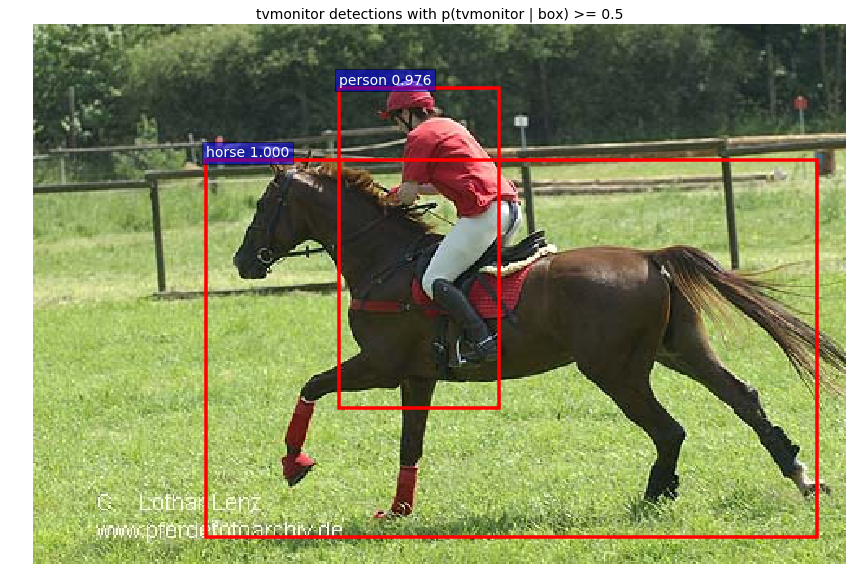

In [14]:
def py_cpu_nms(dets, thresh):
    """Pure Python NMS baseline."""
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    scores = dets[:, 4]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]
    return keep


CLASSES = ('__background__',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair',
           'cow', 'diningtable', 'dog', 'horse',
           'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor')
img = cv2.imread(im_file)
img = img[:, :, (2, 1, 0)]
boxes = pred_boxes
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(img, aspect='equal')
CONF_THRESH = 0.8
NMS_THRESH = 0.3
for cls_ind, cls in enumerate(CLASSES[1:]):
    cls_ind += 1
    cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
    cls_scores = scores[:, cls_ind]
    dets = np.hstack((cls_boxes,
                      cls_scores[:, np.newaxis])).astype(np.float32)
    keep = py_cpu_nms(dets, NMS_THRESH)
    dets = dets[keep, :]
    inds = np.where(dets[:, -1] >= CONF_THRESH)[0]
    
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]

        ax.add_patch(
           plt.Rectangle((bbox[0], bbox[1]),
                      bbox[2] - bbox[0],
                      bbox[3] - bbox[1], fill=False,
                      edgecolor='red', linewidth=3.5)
          )
        ax.text(bbox[0], bbox[1] - 2,
            '{:s} {:.3f}'.format(cls, score),
            bbox=dict(facecolor='blue', alpha=0.5),
            fontsize=14, color='white')

    ax.set_title(('{} detections with '
              'p({} | box) >= {:.1f}').format(cls, cls,
                                              0.5),
              fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()
    
img_path = "./img/"
plt.savefig(img_path+"output_test.jpg")